# Working with Behavior Dataset

For the 2025 NeurlIPS challenge, we provide the following datasets:

1. [2025-challenge-demos](https://huggingface.co/datasets/behavior-1k/2025-challenge-demos): 10000 human-collected teleoperation demos across 50 tasks. It follows the [LeRobot](https://huggingface.co/lerobot) format with some customizations for better data handling. The dataset has the following structure:

| Folder       | Description                                                    |
|--------------|----------------------------------------------------------------|
| annotations  | language annotations for each episode                          |
| data         | low dim data, including proprioceptions, actions, privileged task info, etc. |
| meta         | metadata folder                                                |
| videos       | visual observations, including rgb, depth, seg_instance_id     |

2. [2025-challenge-rawdata](https://huggingface.co/datasets/behavior-1k/2025-challenge-rawdata): the original raw HDF5 data of the 10k teleoperation demos. These files contains everything needed to replay the exact trajectory in OmniGibson. We use this alongside with `OmniGibson/scripts/replay_obs.py` to replay the trajectory and collect addition visual observations.

### Downloading demonstration data

You can make use of `omnigibson.learning.datas.BehaviorLeRobotDataset` for fine-grained data download, for which you can specify which task to download, how many episodes per task, which observation modalities, which camera to use. Below is an example of downloading / loading the demonstration dataset using this class.


Alternatively, If you want to fresh download everything at once, you can use the `snapshot_download` method from huggingface API:

```
snapshot_download(
    repo_id="behavior-1k/2025-challenge-demos",
    repo_type="dataset",
    revision="v2.1",
    local_dir=$PATH_TO_LOCAL_DIR,
    max_workers=$NUM_CPU - 2  
    force_download=True
)
```

In [1]:
from omnigibson.learning.datas.lerobot_dataset import BehaviorLeRobotDataset

# Path to your dataset root
#DATASET_PATH = "/scr/behavior/2025-challenge-demos"
DATASET_PATH = "DATASETS/behavior/2025-challenge-demos"

# Create the dataset
ds = BehaviorLeRobotDataset(
    repo_id="behavior-1k/2025-challenge-demos",
    root=DATASET_PATH,
    episodes=range(2),  # load the first 2 demos for each task
    # Note that data download does not support per-episode granularity, 
    # so it will download all episodes for the two tasks, then load the first 2 demos
    tasks=["turning_on_radio", "picking_up_trash"], # Only load turning_on_radio and picking_up_trash
    modalities=["rgb", "depth", "seg_instance_id"], # load all available modalities
    cameras=["head"],   # only load head camera
    local_only=False,   # download missing files from HF if any
    force_cache_sync=True,  # force sync cache with HF
    # change force_cache_sync to False and local_only to True to save loading time if you already have the data installed 
    chunk_streaming_using_keyframe=True # load observation in chunk for efficient data access, default value
)
print("Dataset size:", len(ds))

Fetching ... files: 0it [00:00, ?it/s]

Fetching ... files: 0it [00:00, ?it/s]

Dataset size: 15095


## Loading and using demonstration dataset

To use the demonstration dataset, one solution is to keep working with `BehaviorLeRobotDataset` with which you can randomly access the data as shown below. 

Following the release of [BEHAVIOR-1K 3.7.1](https://github.com/StanfordVL/BEHAVIOR-1K/releases/tag/v3.7.1), dataset access is no longer truly random due to the use of `chunk_streaming_using_keyframe`. This parameter ignores the index passed to `_getitem_` and instead iteratively returns 250 consecutive data frames starting from a randomly selected key frame. After 250 `_getitem_` calls, it randomly selects another key frame in the dataset and returns the next 250 consecutive frames, enabling faster data access.

The first 2 row in the outputs may appear similar, but they are not identical because they are consecutive frames (see the `assert` statement in the code below).

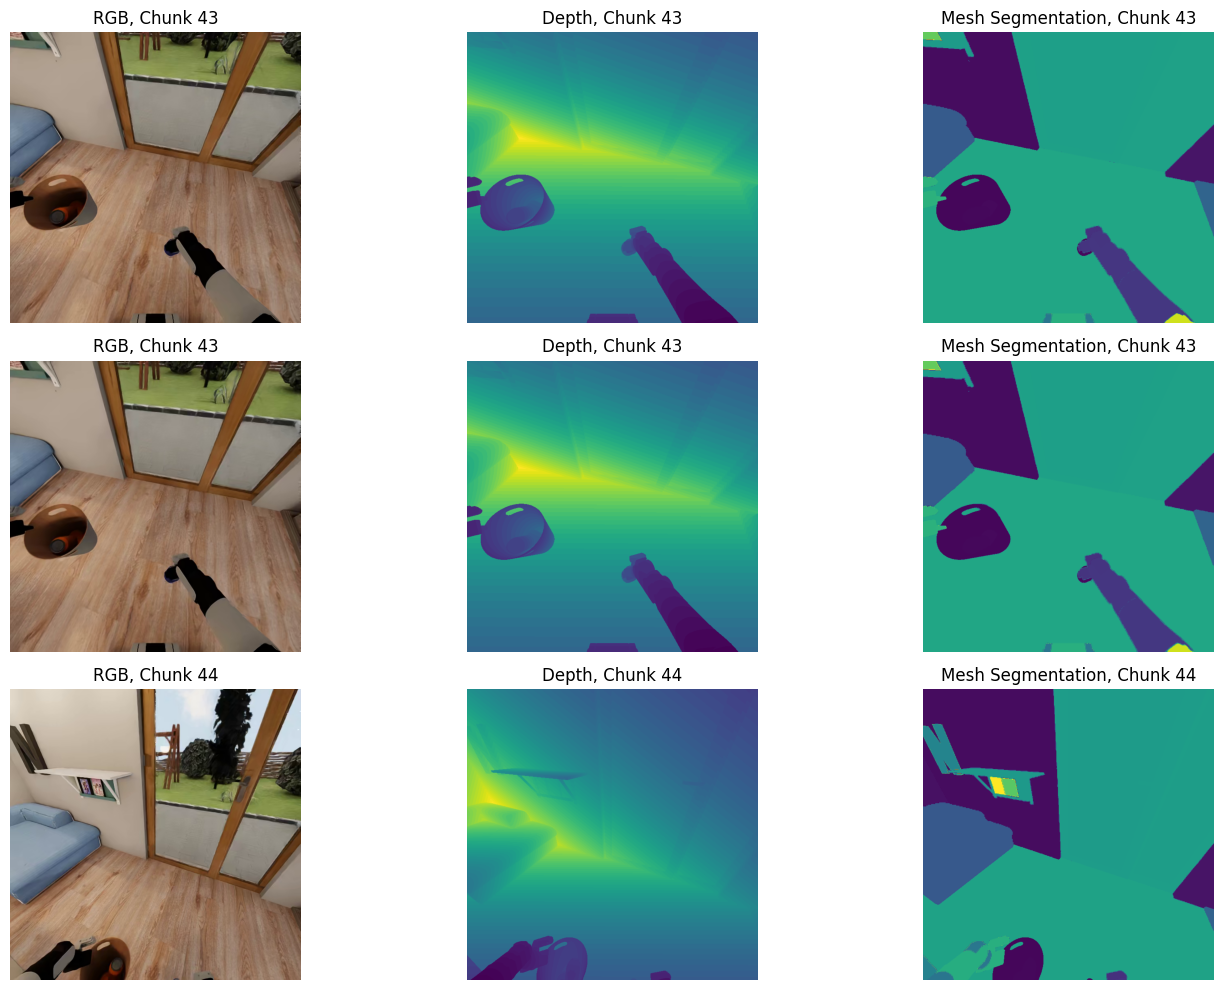

In [2]:
import matplotlib.pyplot as plt
import torch

# Random access a frame
sample_first, sample_last = ds[0], ds[-1]

# The 2 observations are actually different observation
assert not torch.equal(sample_first["observation.images.rgb.head"], sample_last["observation.images.rgb.head"])

fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes[0, 0].imshow(sample_first["observation.images.rgb.head"].movedim(-3, -1))
axes[0, 0].set_title(f"RGB, Chunk {ds.current_streaming_chunk_idx}")
axes[0, 0].axis("off")
axes[0, 1].imshow(sample_first["observation.images.depth.head"])
axes[0, 1].set_title(f"Depth, Chunk {ds.current_streaming_chunk_idx}")
axes[0, 1].axis("off")
axes[0, 2].imshow(sample_first["observation.images.seg_instance_id.head"])
axes[0, 2].set_title(f"Mesh Segmentation, Chunk {ds.current_streaming_chunk_idx}")
axes[0, 2].axis("off")
axes[1, 0].imshow(sample_last["observation.images.rgb.head"].movedim(-3, -1))
axes[1, 0].set_title(f"RGB, Chunk {ds.current_streaming_chunk_idx}")
axes[1, 0].axis("off")
axes[1, 1].imshow(sample_last["observation.images.depth.head"])
axes[1, 1].set_title(f"Depth, Chunk {ds.current_streaming_chunk_idx}")
axes[1, 1].axis("off")
axes[1, 2].imshow(sample_last["observation.images.seg_instance_id.head"])
axes[1, 2].set_title(f"Mesh Segmentation, Chunk {ds.current_streaming_chunk_idx}")
axes[1, 2].axis("off")

# Retrieve observation from a different keyframe (new keyframe is selected every 250 _getitem_ calls)
for i in range(249):
    sample_new_keyframe = ds[0]

axes[2, 0].imshow(sample_new_keyframe["observation.images.rgb.head"].movedim(-3, -1))
axes[2, 0].set_title(f"RGB, Chunk {ds.current_streaming_chunk_idx}")
axes[2, 0].axis("off")
axes[2, 1].imshow(sample_new_keyframe["observation.images.depth.head"])
axes[2, 1].set_title(f"Depth, Chunk {ds.current_streaming_chunk_idx}")
axes[2, 1].axis("off")
axes[2, 2].imshow(sample_new_keyframe["observation.images.seg_instance_id.head"])
axes[2, 2].set_title(f"Mesh Segmentation, Chunk {ds.current_streaming_chunk_idx}")
axes[2, 2].axis("off")

plt.tight_layout()
plt.show()

Alternatively, we also provide `omnigibson.learning.datas.BehaviorIterableDataset`, which is a iterable-style dataset that preload low dim parquet files and lazily load visual observations from MP4 files. It is ddp-ready and provide nice configurability, including setting observation window size, action chunking, action prediction horizon, etc. Here we show a demo of loading the first 2 turning_on_radio trajectories using this dataset (assuming you have already run the code above to download them).

In [3]:
from omnigibson.learning.datas import BehaviorIterableDataset   

first_2_demos = BehaviorIterableDataset.get_all_demo_keys(
    data_path=DATASET_PATH.rsplit("/", 1)[0], 
    task_names=["turning_on_radio"]
)[:2]

iterable_ds = BehaviorIterableDataset(
    data_path=DATASET_PATH.rsplit("/", 1)[0],
    demo_keys=first_2_demos,
    obs_window_size=2,
    ctx_len=8,
    action_prediction_horizon=16,
    downsample_factor=3,    # downsample to 10Hz
    visual_obs_types=["rgb"],
    multi_view_cameras={"head": {
        "name": "robot_r1::robot_r1:zed_link:Camera:0",
        "resolution": [240, 240]
    }}  # camera config, see omnigibson/learning/configs/robot/r1pro.yaml
)

In [4]:
batch = next(iter(iterable_ds))
print("keys: ", batch.keys())
print("base actions: ", batch["actions"]["base"])

keys:  dict_keys(['obs', 'actions', 'masks'])
base actions:  tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.1565],
        [ 0.0000,  0.0000, -0.2501],
        [ 0.0000,  0.0000, -0.2746]])


## Data Format
1. Metadata

Apart from dataset-wise high level metadata, we also have per episode metadata stored under `meta/episodes`. These json contains some useful information:

- task_obs_keys: a list of task-relevant objects whose poses are stored in observation::task_info in the parquet file. (NOTE: standard track participants should NOT use this)
- ins_id_mapping: a dictionary mapping instance id to mesh name. This is useful to recover the instance / semantic of a instance id segmentation.
- unique_ins_ids for each camera: this stores all the unique instance ids that has every come within view of a specific camera. 
- config: the original config file which can be used to spawn the scene.


2. Low dim data

Low dim data are stored in parquet files under `data` folder, and consist of low-dimention non-visual observation data of the following:

- episode_index: the index of the episode the data belongs to
- task_index: index of the task the data belongs to, see `omnigibson.learning.utils.eval_utils.TASK_NAME_TO_INDICES` for the task index mapping
- observation.state: a 258-dim tensor of robot proprioception data, see `omnigibson.learning.utils.eval_utils.PROPRIOCEPTION_INDICES` for the corresponding meaning of each index.
- observation.cam_rel_poses: a 21-dim tensor of robot camera poses (pos, quat) relative to robot base, in the order of left wrist, right wrist, head.
- action: a 23-dim tensor of robot absolute joint position actions, see `omnigibson.learning.utils.eval_utils.ACTION_QPOS_INDICES` for the corresponding meaning of each idnex
- observation.task_info: privileged task information (This should not be USED for standard track participants.) These essentially stores the pose of task-relevant objects. The meaning of each index is stored in the metadata json file as discussed above.

Also FYI, there are other useful macros within eval_utils, including joint range, default camera intrinsics, etc. Please refer to `eval_utils.py` if you are interested. 

Below, we load a sample parquet file to display some actual data. 

In [5]:
import pandas as pd
f_lowdim = pd.read_parquet(f"{DATASET_PATH}/data/task-0000/episode_00000010.parquet")
f_lowdim

,index,episode_index,task_index,timestamp,observation.state,observation.cam_rel_poses,action,observation.task_info
0,0,10,0,0.000000,"[0.7048771381378174, -0.13113544881343842, -0....","[0.17456889, 0.25489283, 0.50073487, -0.169874...","[-1e-45, -1e-45, 1e-45, 1.025, -1.45, -0.47, 0...","[1.0, 4.6943197, 5.190511, 0.0049960613, 0.999..."
1,1,10,0,0.033333,"[0.7048768401145935, -0.13113567233085632, -0....","[0.1750884, 0.2553525, 0.5006543, -0.17060505,...","[-1e-45, -1e-45, 1e-45, 1.025, -1.45, -0.47, 0...","[1.0, 4.6943197, 5.190511, 0.004995063, 0.9999..."
2,2,10,0,0.066667,"[0.7048771381378174, -0.13113602995872498, -0....","[0.177073, 0.2553606, 0.50080407, -0.16905701,...","[-1e-45, -1e-45, 1e-45, 1.025, -1.45, -0.47, 0...","[1.0, 4.6943192, 5.1905117, 0.0049951375, 0.99..."
3,3,10,0,0.100000,"[0.7048767805099487, -0.13113579154014587, -0....","[0.17713976, 0.25536013, 0.5008195, -0.1689359...","[-1e-45, -1e-45, 1e-45, 1.025, -1.45, -0.47, 0...","[1.0, 4.6943192, 5.1905117, 0.0049951077, 0.99..."
4,4,10,0,0.133333,"[0.7048768401145935, -0.13113556802272797, -0....","[0.1771419, 0.2553587, 0.5008197, -0.16893221,...","[-1e-45, -1e-45, 1e-45, 1.025, -1.45, -0.47, 0...","[1.0, 4.6943197, 5.190511, 0.0049951375, 0.999..."
...,...,...,...,...,...,...,...,...
1951,1951,10,0,65.033333,"[0.4221701920032501, -0.8321728706359863, -0.0...","[0.20895767, 0.2775154, 0.6487709, -0.23602346...","[-1e-45, -1e-45, 1e-45, 0.54593694, -0.5751893...","[1.0, 4.424031, 5.8964295, 0.0049952567, 0.999..."
1952,1952,10,0,65.066667,"[0.42217037081718445, -0.8321729898452759, -0....","[0.20881414, 0.2775154, 0.6487802, -0.23609135...","[-1e-45, -1e-45, 1e-45, 0.54593694, -0.5751893...","[1.0, 4.4240303, 5.89643, 0.0049952567, 0.9999..."
1953,1953,10,0,65.100000,"[0.42217040061950684, -0.8321731686592102, -0....","[0.20875883, 0.2775159, 0.6487835, -0.2361176,...","[-1e-45, -1e-45, 1e-45, 0.54593694, -0.5751893...","[1.0, 4.4240303, 5.89643, 0.004995227, 0.99999..."
1954,1954,10,0,65.133333,"[0.4221704602241516, -0.8321730494499207, -0.0...","[0.20868206, 0.2775154, 0.6487885, -0.23615356...","[-1e-45, -1e-45, 1e-45, 0.54593694, -0.5751893...","[1.0, 4.4240303, 5.89643, 0.0049952716, 0.9999..."


3. Visual Observations:

Visual observations are stored as mp4 files in `videos`. It consists of three modalities: `rgb`, `depth_linear`, and `seg_instance_id`, where `depth_linear` is just the depth map, and `seg_instance_id` is the mesh-level segmentation. A sample of these modalities is showed in the previous cell when loading the LeRobot dataset. We also provide custom video loaders in `omnigibson.learning.utils.obs_utils.OBS_LOADER_MAP`. We recorded visual observations from three cameras on the robot: one head camera and two wrist cameras. Below, we show the rgb image of each of them 

Please take a look at `info.json` within the dataset to get more information regarding this part of the data, including their resolution and encoding method. Here, we provide an example of using the observation loaders from `obs_utils.py`:

In [6]:
from omnigibson.learning.utils.obs_utils import OBS_LOADER_MAP
from omnigibson.learning.utils.eval_utils import ROBOT_CAMERA_NAMES

video_loaders = []
for camera_id in ROBOT_CAMERA_NAMES["R1Pro"]:
    video_loaders.append(OBS_LOADER_MAP["rgb"](
        data_path=DATASET_PATH,
        task_id=0,
        camera_id=camera_id,
        demo_id="00000010",
        output_size=(360, 360),
        batch_size=1,
    ))

frames = [next(i)[0] for i in iter(video_loaders)]

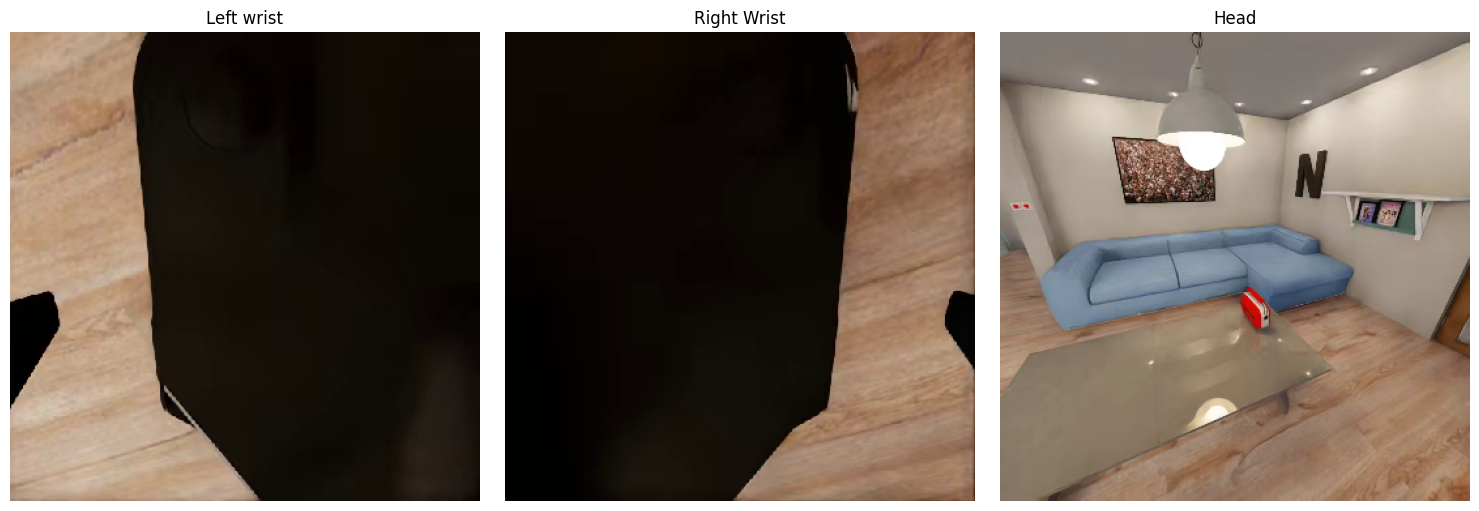

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(frames[0].movedim(-3, -1))
axes[0].set_title("Left wrist")
axes[0].axis("off")
axes[1].imshow(frames[1].movedim(-3, -1))
axes[1].set_title("Right Wrist")
axes[1].axis("off")
axes[2].imshow(frames[2].movedim(-3, -1))
axes[2].set_title("Head")
axes[2].axis("off")

plt.tight_layout()
plt.show()

4. Language annotations:

Language annotations are located in the `annotations` folder. We currently release annotation for 17 tasks, and are expected to make available the rest soon. These annotation json files contains skill & primitive level annotations to aid robot learning policy.

In [8]:
import json
import pprint

with open(f"{DATASET_PATH}/annotations/task-0000/episode_00000010.json", "r") as f:
    annotations = json.load(f)

pprint.pprint(annotations)

{'data_folder': '',
 'meta_data': {'task_duration': 1776, 'valid_duration': [0, 1776]},
 'primitive_annotation': [{'frame_duration': [0, 1162],
                           'manipulating_object_id': ['radio_89'],
                           'memory_prefix': [],
                           'object_id': [['radio_89', 'coffee_table_koagbh_0']],
                           'primitive_description': ['pick up from'],
                           'primitive_id': [2],
                           'primitive_idx': 0,
                           'skill_idxes': [0, 1],
                           'spatial_prefix': []},
                          {'frame_duration': [1162, 1434],
                           'manipulating_object_id': ['radio_89'],
                           'memory_prefix': [],
                           'object_id': [['radio_89']],
                           'primitive_description': ['press'],
                           'primitive_id': [67],
                           'primitive_idx': 1,
      